In [24]:
import os
import sys
import numpy as np
import glob
import random
import random as python_random
from pathlib import Path
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline

os.environ['PYTHONHASHSEED'] = '120'
python_random.seed(120)
np.random.seed(120)
tf.random.set_seed(120)

## Segmentation

Fish dataset provides also masks for each image so that we can train the simple binary segmentation model. For this purpose I will build a UNet network from scratch as a first model and then I will use a pretrained part of the other model to modify it.

Preprocessing steps are similar to the classification task but here we do not have classes as labels but masks. So that we have to read images together with masks which are in different directories.

In [781]:
filepath = Path('Fish_Dataset')

In [782]:
dirpaths_im = [name for name, _, _ in os.walk(filepath)][2:11]
dirpaths_mask = [name for name, _, _ in os.walk(filepath)][12:]

In [783]:
dirpaths_im

['Fish_Dataset\\classification\\Black Sea Sprat',
 'Fish_Dataset\\classification\\Gilt-Head Bream',
 'Fish_Dataset\\classification\\Hourse Mackerel',
 'Fish_Dataset\\classification\\Red Mullet',
 'Fish_Dataset\\classification\\Red Sea Bream',
 'Fish_Dataset\\classification\\Sea Bass',
 'Fish_Dataset\\classification\\Shrimp',
 'Fish_Dataset\\classification\\Striped Red Mullet',
 'Fish_Dataset\\classification\\Trout']

In [784]:
dirpaths_mask

['Fish_Dataset\\segmentation\\Black Sea Sprat GT',
 'Fish_Dataset\\segmentation\\Gilt-Head Bream GT',
 'Fish_Dataset\\segmentation\\Hourse Mackerel GT',
 'Fish_Dataset\\segmentation\\Red Mullet GT',
 'Fish_Dataset\\segmentation\\Red Sea Bream GT',
 'Fish_Dataset\\segmentation\\Sea Bass GT',
 'Fish_Dataset\\segmentation\\Shrimp GT',
 'Fish_Dataset\\segmentation\\Striped Red Mullet GT',
 'Fish_Dataset\\segmentation\\Trout GT']

Since filenames of masks and images are the same, we can shuffle the filenames and then create paths to these files. This way the order of shuffle is preserved in image and mask directories. We also resize our images to size of 128 x 128.

In [336]:
# random.seed(120)

def get_images(dirpaths_im, dirpaths_mask, img_size):
    X = []
    y = []
    for path_im, path_mask in zip(dirpaths_im, dirpaths_mask):
        filenames_im = [filename for filename in files for root, dirs, files in os.walk(dirpaths_im[0])]
        random.shuffle(filenames_im)
        filepaths_im = [path_im + '\\' + filename_im for filename_im in filenames_im][:500]
        filepaths_mask = [path_mask + '\\' + filename_im for filename_im in filenames_im][:500]
        X.extend([cv2.cvtColor(cv2.resize(cv2.imread(filepath_im), (img_size, img_size)), cv2.COLOR_BGR2RGB) for filepath_im in filepaths_im])
        y.extend([np.expand_dims(cv2.resize(cv2.imread(filepath_mask, -1), (img_size, img_size)), axis=-1) for filepath_mask in filepaths_mask])
        
    return X, y

In [337]:
image_size = 128
X, y = get_images(dirpaths_im, dirpaths_mask, img_size=image_size)

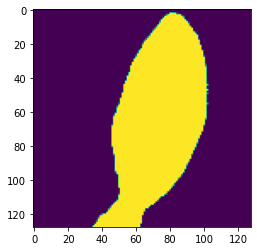

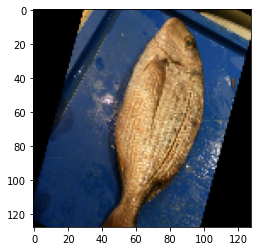

In [790]:
plt.imshow(y[0])
plt.show()
plt.imshow(X[0])

In [338]:
dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(len(X))
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = int(0.1 * len(dataset))

train_set = dataset.take(train_size)
val_set = dataset.skip(train_size)

val_set = val_set.skip(val_size)
test_set = val_set.take(test_size)

Now we have to create a serialized protocol buffers from pairs of 2 images instead of image and a label. 

In [347]:
BytesList = tf.train.BytesList
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

def create_example(image, mask):
    image_data = tf.io.serialize_tensor(image)
    mask_data = tf.io.serialize_tensor(mask)
    return Example(features=Features(
            feature={
                'image': Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                'mask': Feature(bytes_list=BytesList(value=[mask_data.numpy()]))
            }))

In [348]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, dataset_type=None, n_shards=5):
    dirpath = 'tf_records_segmentation'
    paths = [dirpath + '/' + dataset_type + '/' + "{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, mask) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, mask)
            writers[shard].write(example.SerializeToString())
    return paths

In [349]:
train_filepaths = write_tfrecords("train", train_set, dataset_type='train')
valid_filepaths = write_tfrecords("valid", val_set, dataset_type='valid')
test_filepaths = write_tfrecords("test", test_set, dataset_type='test')

We also have to modify the *preprocess* function slightly. Since we build our model from scratch we dont have to use any external preprocessing function. We should also normalize our images (it was done before using the Xception preprocessing function).

In [613]:
def preprocess(tfrecord):
    feature_descriptions = {
        'image': tf.io.FixedLenFeature([], tf.string, default_value=''),
        'mask': tf.io.FixedLenFeature([], tf.string, default_value='')
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example['image'], out_type=tf.uint8)
    mask = tf.io.parse_tensor(example['mask'], out_type=tf.uint8)
    
    image = tf.cast(image, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    
    image = image / 255.0
    mask = mask / 255.0
    
    return image, mask

def prep_dataset(filepaths, n_read_threads=6, shuffle_buffer_size=None,
                n_parse_threads=6, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=n_read_threads)
    
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [614]:
train_set = prep_dataset(train_filepaths, shuffle_buffer_size=10000)
valid_set = prep_dataset(valid_filepaths)
test_set = prep_dataset(test_filepaths)

Now we can start building our model. The UNet network consists of a Downsampling, Upsampling and Bottleneck blocks. Every downsampling block reduces the image size by 2 using a *MaxPool2D* layer. Convolutional layers output the same size due to the *same* padding. Downsampling block outputs an output from the 2nd *Conv2D* layer and from the *MaxPool2D* layer. The first one is then used in the upsampling block as a skip connection. The second is fed into the next downsapling block as the input. We use 4 such downsampling blocks to get the image from 128 x 128 to 8 x 8. Then the bottleneck layer is just changing the number of channels and its output is fed into the first upsampling block. Here the input size is increased by 2 using the *UpSampling2D* layer and concatenated with the skip connection from the respective downsampling block. Then there are 2 *Conv2D* layers as before. This process is repeated to the point when the output of the upsampling block has size of 128 x 128. Then the last layer is a simple *Conv2D* layer with a single filter of size 1 and a *sigmoid* activation function so we will get the prediction map of size 128 x 128 x 1. Each pixel will describe a probability of belonging to an object class. If we will have eg. 3 different object to segment then we should use a *softmax* activation function and 3 filters in the last layer so that each channel for every pixel will correspond to different object probability.

In [615]:
def down_block(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    c  = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c  = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    p = keras.layers.MaxPool2D((2, 2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 3), padding='same', strides=1):
    us = keras.layers.UpSampling2D((2, 2))(x)
    concat = keras.layers.Concatenate()([us, skip])
    c  = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(concat)
    c  = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 3), padding='same', strides=1):
    c  = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(x)
    c  = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation='relu')(c)
    return c

In [616]:
def UNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input(shape=[image_size, image_size, 3])
    
    c1, p1 = down_block(inputs, f[0])#128 -> 64
    c2, p2 = down_block(p1, f[1])#64 -> 32
    c3, p3 = down_block(p2, f[2])#32 -> 16
    c4, p4 = down_block(p3, f[3])#16 -> 8
    
    bn = bottleneck(p4, f[4])
    
    u1 = up_block(bn, c4, f[3])#8 -> 16
    u2 = up_block(u1, c3, f[2])#16 -> 32
    u3 = up_block(u2, c2, f[1])#32 -> 64
    u4 = up_block(u3, c1, f[0])#64 -> 128
    
    outputs = keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid')(u4)
    model = keras.models.Model(inputs, outputs)
    return model

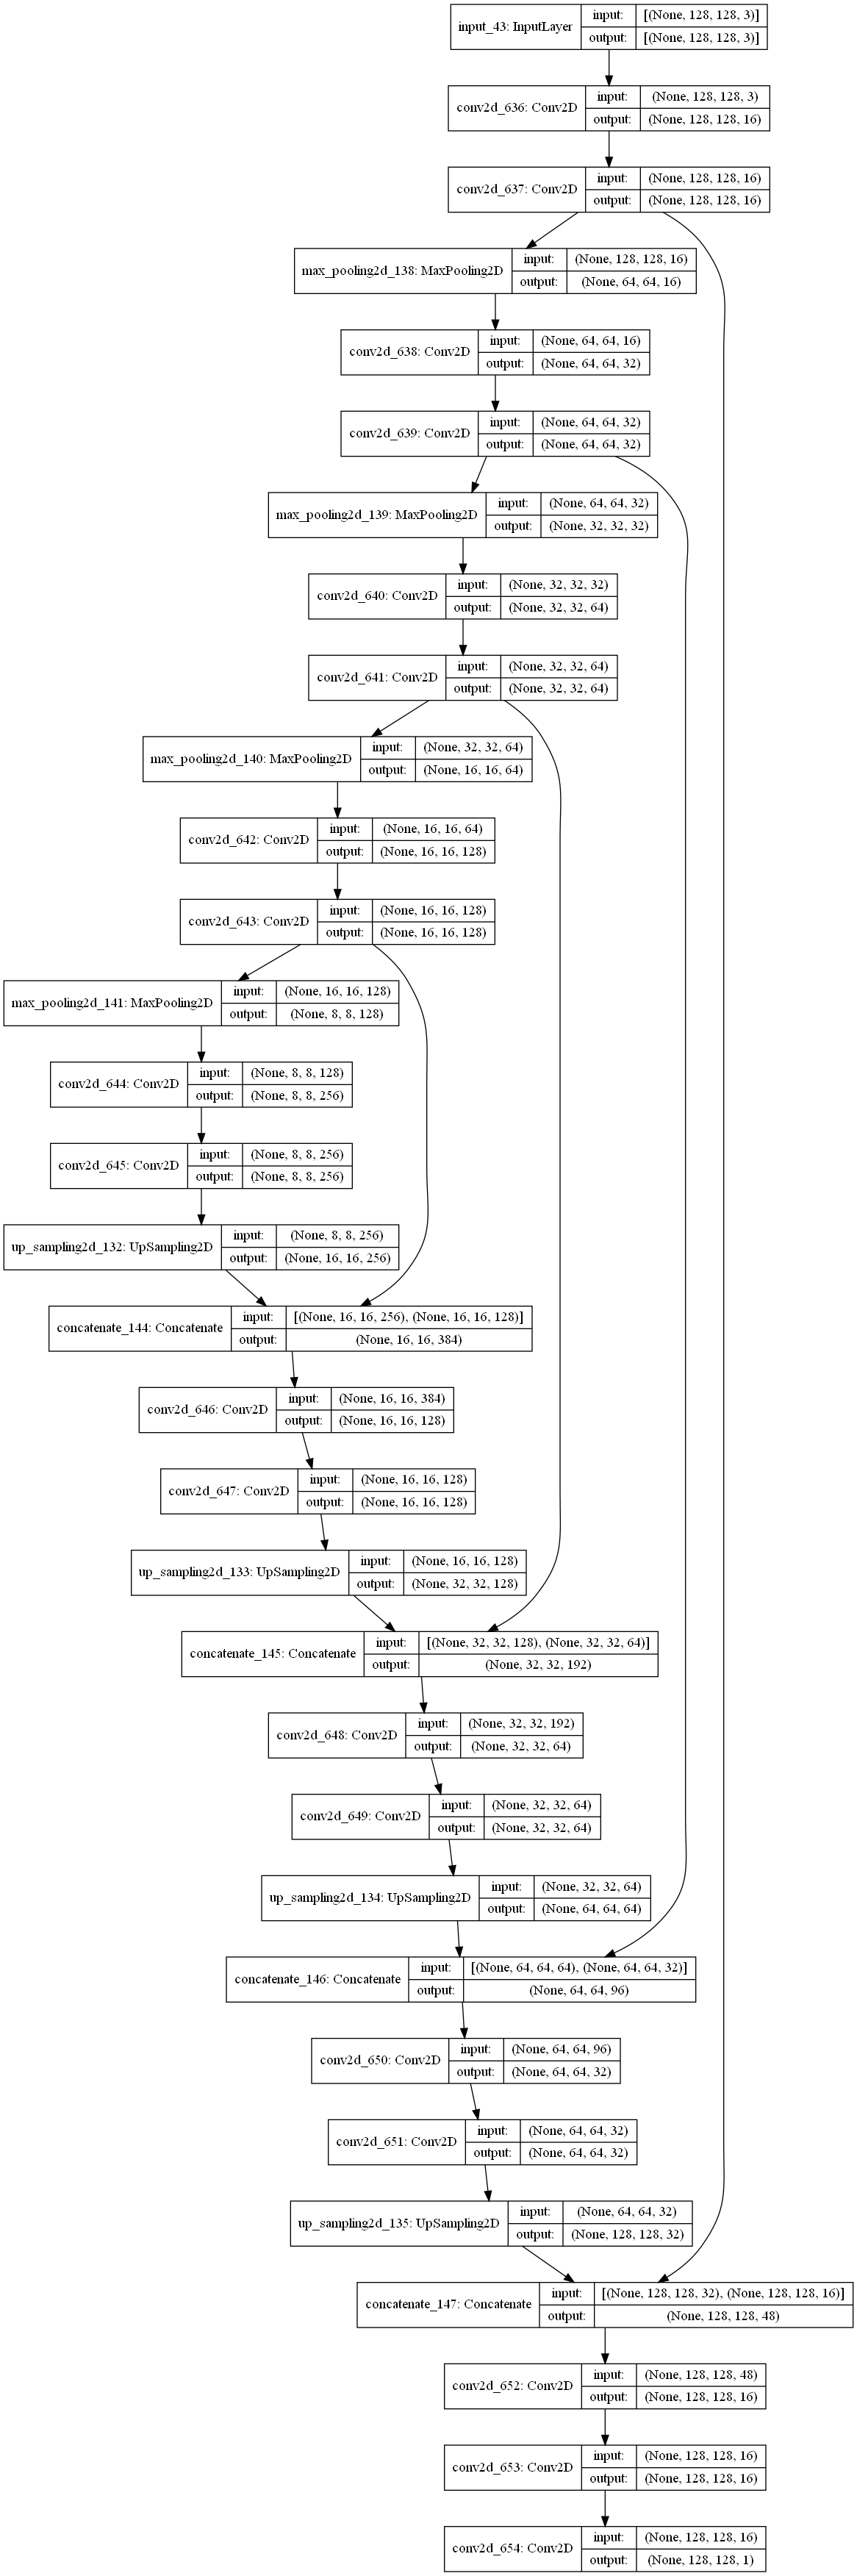

In [832]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('fish_model_seg_scratch.h5', save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

model = UNet()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
keras.utils.plot_model(model, show_shapes=True)

Training was again done on the Google Colab to speed it up. But at the first try I got an error about the unknown tensor shape which I could not solve. To overcome this problem I took the first batch from the dataset and I have started training on it and immediately stopped. Then after passing the right train set it worked. I will try to figure out what was the problem.

In [794]:
for i in train_set.take(1):
    X = i[0]
    y = i[1]

In [798]:
batch_size = 32
train_steps = train_size // batch_size
valid_steps = val_size // batch_size

history = model.fit(train_set, epochs=10, steps_per_epoch=train_steps, validation_steps=valid_steps, validation_data=valid_set,
                   callbacks=[checkpoint_cb, early_stopping])

Before looking at the predictions lets first try to build UNet using some parts of the pretrained model.

## Pretrained downsampling block

Here we will take some of the layers from the *MobileNetV2* model to build a downsampling block. We not gonna train these layers. Then we will add the regular upsampling blocks taken from the GAN pix2pix model. Additionally there is no bottleneck layer inbetween in this model. The last layer is the *Conv2DTranspose* layer which will upsample its input from 64 x 64 to 128 x 128 and a single channel as before.

This model was also trained on the Google Colab.

In [634]:
base_model = keras.applications.MobileNetV2(input_shape=[image_size, image_size, 3], include_top=False)

layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [635]:
from tensorflow_examples.models.pix2pix import pix2pix

up_stack = [
    pix2pix.upsample(512, 3),# 4x4 -> 8x8
    pix2pix.upsample(256, 3),# 8x8 -> 16x16
    pix2pix.upsample(128, 3),# 16x16 -> 32x32
    pix2pix.upsample(64, 3),# 32x32 -> 64x64
]

In [636]:
def unet_model(output_channels):
    inputs = keras.layers.Input(shape=[image_size, image_size, 3])
    
    #Downsampling
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])
    
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = keras.layers.Concatenate()
        x = concat([x, skip])
    
    last = keras.layers.Conv2DTranspose(output_channels, 3, strides=2, padding='same')# 64x64 -> 128x128
    x = last(x)
    
    return keras.Model(inputs=inputs, outputs=x)

In [642]:
model_pretrained = unet_model(1)
model_pretrained.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

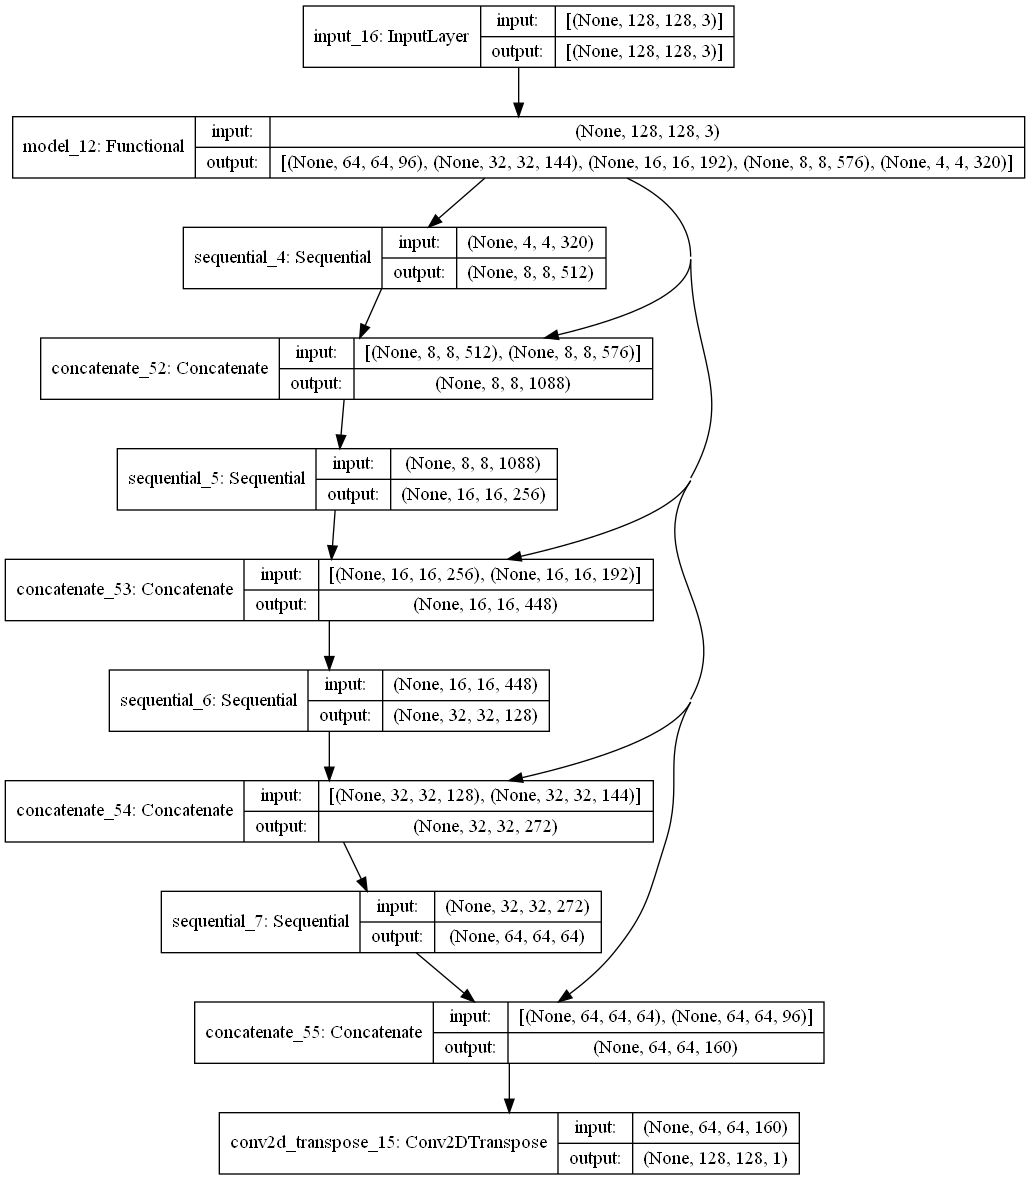

In [831]:
keras.utils.plot_model(model_pretrained, show_shapes=True)

In [800]:
checkpoint_cb = keras.callbacks.ModelCheckpoint('fish_model_seg_pretrained.h5', save_best_only=True)

early_stopping = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

history_pretrained = model_pretrained.fit(train_set, epochs=10,
                          steps_per_epoch=train_steps,
                          validation_steps=valid_steps,
                          validation_data=valid_set, callbacks=[checkpoint_cb, early_stopping])

## Inference

Now we have our models trained so lets look at the predictions on the train set.

In [801]:
model_scratch = keras.models.load_model('fish_model_seg_scratch.h5')
model_pretrained = keras.models.load_model('fish_model_seg_pretrained.h5')

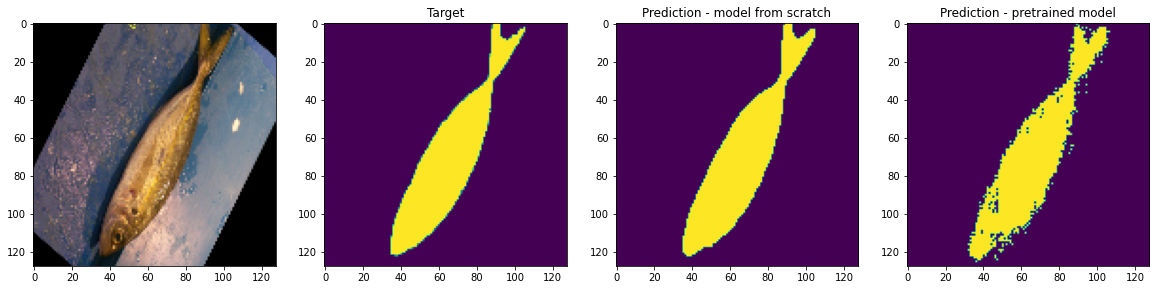

In [830]:
im_number = 28
threshold = 0.5
fig, ax = plt.subplots(1,4, figsize=(20,20))
for x in test_set.take(1):
    ax[0].imshow(x[0][im_number])
    ax[1].imshow(x[1][im_number])
    ax[1].set_title('Target')
    
    yhat = model_scratch.predict(np.expand_dims(x[0][im_number], axis=0))
    yhat = yhat > threshold
    ax[2].imshow(yhat[0])
    ax[2].set_title('Prediction - model from scratch')
    
    yhat = model_pretrained.predict(np.expand_dims(x[0][im_number], axis=0))
    yhat = yhat > threshold
    ax[3].imshow(yhat[0])
    ax[3].set_title('Prediction - pretrained model')

As we could see, our model build from scratch performs very well and predicts masks almost identical to the target. The pretrained model did not perform so good. After training for some epochs we should make the base model layers trainable but there was a problem I have described above. Training time for both models was very similar on Colab and after 10 epochs the basic model gave much better results so we should pick it.